In [1]:
# calcul matriciel
import numpy as np
# structures de données dataframe
import pandas as pd
# utilisation des modèles
import tensorflow as tf
# visualisation statistique et images
import matplotlib.pyplot as plt

2024-04-16 14:22:12.946701: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 14:22:12.947814: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 14:22:12.987803: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-16 14:22:13.115746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 14:22:13.871224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [2]:
class MNISTLoader:
  def __init__(self):
    self.x_train = None
    self.y_train = None
    self.x_test = None
    self.y_test = None
    self.x_train_reshaped = None
    self.x_test_reshaped = None

  def load_data(self):
    (self.x_train, self.y_train), (self.x_test, self.y_test) = tf.keras.datasets.mnist.load_data()
    self.x_test_reshaped = self.x_test.reshape(-1, 28*28)
    self.x_train_reshaped = self.x_train.reshape(-1, 28*28)

  def display_digit_distribution(self):
    # Calculer la distribution des chiffres dans l'ensemble d'apprentissage
    train_counts = np.bincount(self.y_train)
    train_digits = np.nonzero(train_counts)[0]

    # Calculer la distribution des chiffres dans l'ensemble de test
    test_counts = np.bincount(self.y_test)
    test_digits = np.nonzero(test_counts)[0]

    # Tracer les graphiques de distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.bar(train_digits, train_counts[train_digits])
    ax1.set_title('Distribution des chiffres - Entraînement')
    ax1.set_xlabel('Chiffre')
    ax1.set_ylabel('Nombre d\'occurrences')

    ax2.bar(test_digits, test_counts[test_digits])
    ax2.set_title('Distribution des chiffres - Test')
    ax2.set_xlabel('Chiffre')
    ax2.set_ylabel('Nombre d\'occurrences')

    plt.show()


  def display_image(self, dataset, index):
    if dataset == 'train':
      image = self.x_train[index]
      label = self.y_train[index]
    elif dataset == 'test':
      image = self.x_test[index]
      label = self.y_test[index]
    else:
      raise ValueError('invalid argument dataset')

    plt.imshow(image, cmap='gray')
    plt.title(f'Image {index} - Chiffre: {label}')
    plt.axis('off')
    plt.show()


  def display_digit_means(self):
    digit_means_train = []
    digit_means_test = []

# pour chaque digit on fait la moyenne de la valeur de chaque pixel pour créer une nouvelle image
    for digit in range(10):
    # on prends toutes les images pour lesquelles le label = à l'index (0 sur le premier tour de loop)
      digit_images_train = self.x_train[self.y_train == digit]
      digit_images_test = self.x_test[self.y_test == digit]

      digit_mean_train = np.mean(digit_images_train, axis=0)
      digit_mean_test = np.mean(digit_images_test, axis=0)

      digit_means_train.append(digit_mean_train)
      digit_means_test.append(digit_mean_test)

    # Affichage des moyennes des chiffres
    fig, axs = plt.subplots(2, 10, figsize=(20, 6))

    for i in range(10):
      axs[0, i].imshow(digit_means_train[i], cmap='gray')
      axs[0, i].set_title(f'Moyenne - Chiffre {i}')
      axs[0, i].axis('off')

      axs[1, i].imshow(digit_means_test[i], cmap='gray')
      axs[1, i].set_title(f'Moyenne - Chiffre {i}')
      axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
loader = MNISTLoader()
loader.load_data()

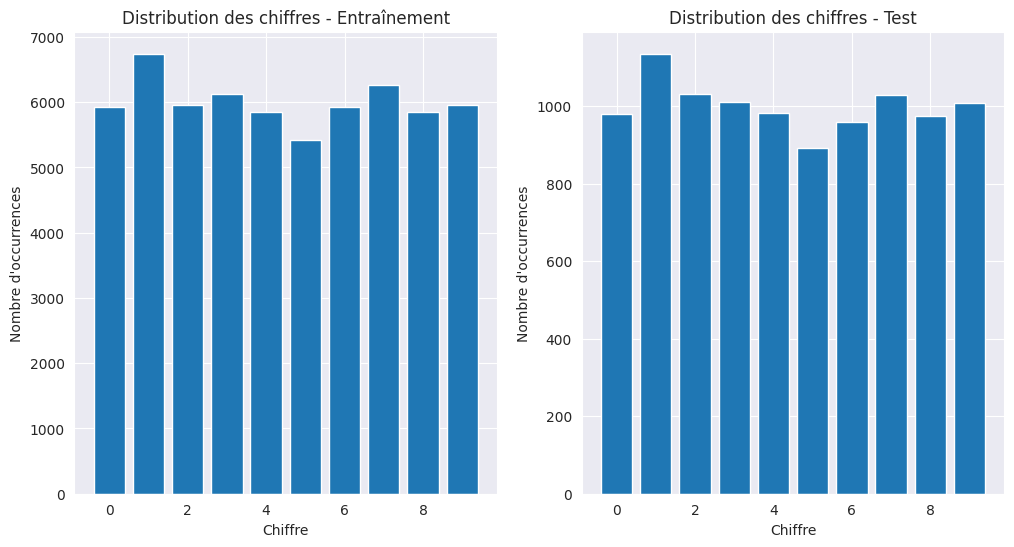

In [22]:
loader.display_digit_distribution()

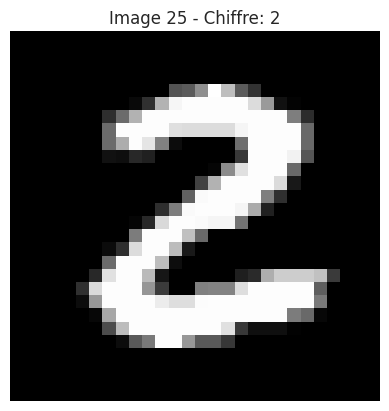

In [23]:
loader.display_image('train', 25)

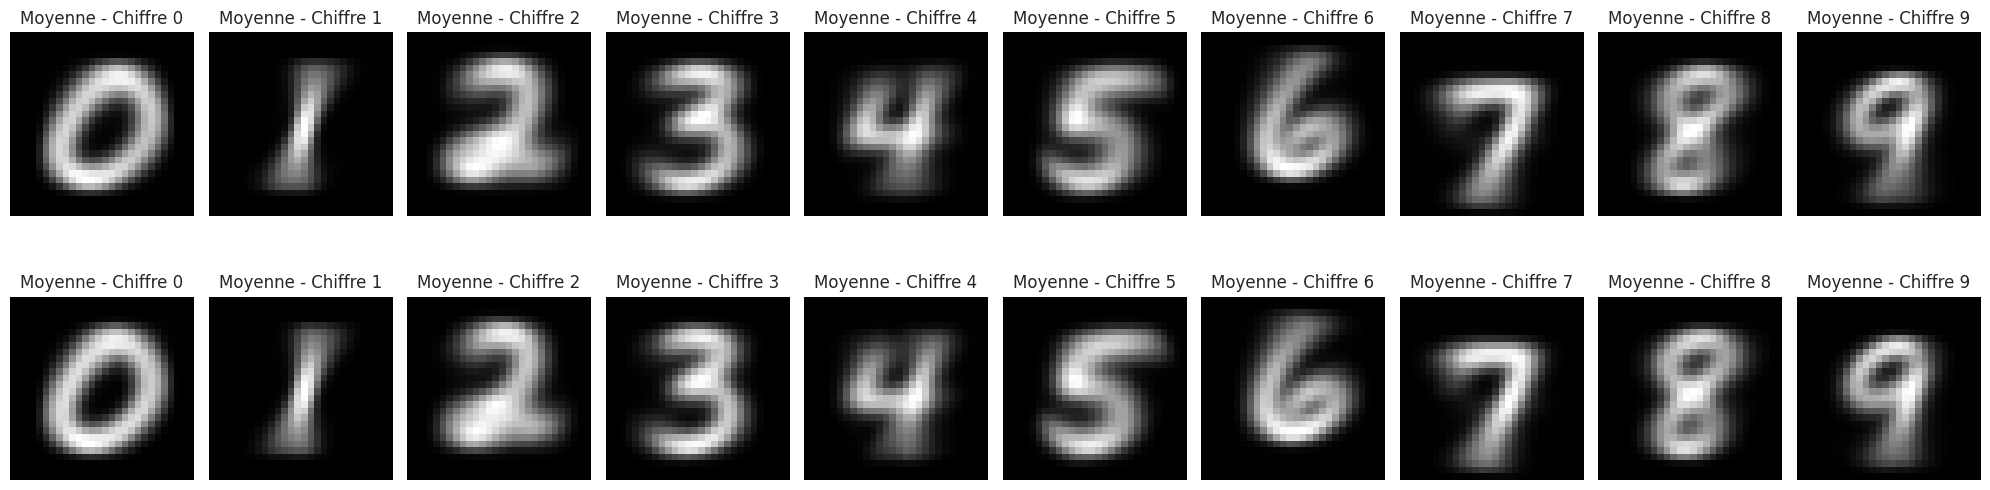

In [24]:
loader.display_digit_means()

In [25]:
print("Dimension du dataset apprentissage : ", loader.x_train.shape)
print("Dimension du dataset apprentissage remodelé : ", loader.x_train_reshaped.shape)
print("Dimension du dataset test : ", loader.x_test.shape)
print("Dimension du dataset test remodelé : ", loader.x_test_reshaped.shape)

Dimension du dataset apprentissage :  (60000, 28, 28)
Dimension du dataset apprentissage remodelé :  (60000, 784)
Dimension du dataset test :  (10000, 28, 28)
Dimension du dataset test remodelé :  (10000, 784)


# Recap première partie
## chargement des données
TensorFlow nous à permis de récupérer automatiquement les données MNIST dans 4 datasets différents : le dataset d'entrainement et de test.

C'est deux datasets sont divisé en X et Y, Le dataset X contient les données, donc les images. Le dataset Y contient les labels, donc les réponses attendues.

## statistiques sur les données
Grâce à matplotlib on à pu facilement afiché la distribution de chaque digit dans les datasets. En clair, on à affiché par exemple le nombre de "1" dans le dataset d'entrainement.

## affichage de l'image
Toujours grâce à matplotlib on peut afficher facilement une des images des datasets.

## digit means
Numpy nous permet de faire des moyennes de matrices. En clair, on fait la moyenne de chaque valeure de chacun des 784 pixels pour toutes les images correspondant à un "8" par exemple.

On affiche ensuite l'image générée par la moyenne de chacune des autres image.

## reshape
Pour finir on à remodelé notre tableau de matrices (donc un tableau en deux dimensions) en un tableau de tableaux (donc une matrice).

Ce processus est nécessaire car un algorithme d'apprentissage comme on va utiliser ensuite prends une matrice en entrée et non un tableau en 3 dimensions.

# Partie deux : modèle d'apprentissage

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# modèle déjà prêt de scikit learn qui utilise plusieurs arbres de décisions où chaque noeud est un else-if
model = RandomForestClassifier()
# entraînement du modèle
model.fit(loader.x_train_reshaped, loader.y_train)

# tentative de prédiction du modèle entrainé
y_pred = model.predict(loader.x_test_reshaped)

# taux de réussite des prédictions
accuracy = accuracy_score(loader.y_test, y_pred)
print("Accuracy : ", accuracy)

Accuracy :  0.9693


In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# modèle KNN proposé dans le bootsrap qui se base sur la moyenne (expliqué dans le recap plus haut)
model = KNeighborsClassifier()
# entraînement du modèle
model.fit(loader.x_train_reshaped, loader.y_train)

# tentative de prédiction du modèle entrainé
y_pred = model.predict(loader.x_test_reshaped)

# taux de réussite des prédictions
accuracy = accuracy_score(loader.y_test, y_pred)
print("Accuracy : ", accuracy)

Accuracy :  0.9688


In [28]:
# ATTENTION ce script est très long
# on essais en modifiant l'hyper parametre du nombre de voisin,
# afin de faire varier sa sensibilité aux aberrations et de trouver la meilleure valeur
for i in range(10):
  if i != 0:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(loader.x_train_reshaped, loader.y_train)

    y_pred = model.predict(loader.x_test_reshaped)

    accuracy = accuracy_score(loader.y_test, y_pred)
    print("nb neighbours : ", i)
    print("Accuracy : ", accuracy)
    print("-----------------------")

nb neighbours :  1
Accuracy :  0.9691
-----------------------
nb neighbours :  2
Accuracy :  0.9627
-----------------------
nb neighbours :  3
Accuracy :  0.9705
-----------------------
nb neighbours :  4
Accuracy :  0.9682
-----------------------
nb neighbours :  5
Accuracy :  0.9688
-----------------------
nb neighbours :  6
Accuracy :  0.9677
-----------------------
nb neighbours :  7
Accuracy :  0.9694
-----------------------
nb neighbours :  8
Accuracy :  0.967
-----------------------
nb neighbours :  9
Accuracy :  0.9659
-----------------------


In [29]:
# On test le modèle sur les données d'entraînement
model = KNeighborsClassifier()
model.fit(loader.x_train_reshaped, loader.y_train)

# tentative de prédiction du modèle entrainé
y_pred = model.predict(loader.x_train_reshaped)

# taux de réussite des prédictions
accuracy = accuracy_score(loader.y_train, y_pred)
print("Accuracy : ", accuracy)

Accuracy :  0.9819166666666667


In [30]:
# cross validation
from sklearn.model_selection import cross_val_score

model = KNeighborsClassifier()
model.fit(loader.x_train_reshaped, loader.y_train)

# validation croisée en 5 plis
scores = cross_val_score(model, loader.x_train_reshaped, loader.y_train, cv=5, scoring='accuracy')

print("Scores : ", scores)
print("Précision moyenne : {:.4f}", format(scores.mean()))

Scores :  [0.96975    0.97016667 0.96933333 0.96816667 0.969     ]
Précision moyenne : {:.4f} 0.9692833333333335


on fait faire une prédiction par le modèle.# Partie 2
## questions
### Why use a separate dataset to measure the performance of an algorithm ? | What are your results when you test your algorithm on the same dataset used in training?
Lors de la phase d'apprentissage, le modèle connais les réponses afin de pouvoir s'améliorer par lui même. On ne peut donc le tester sur les données d'entraînement car il s'est entrainé à avoir 100% sur ces données précisément !

Logiquement le résultat est donc proche de 100% de réussite (voir test plus haut), mais ce résultat n'as pas de valeur.

Les tests on montré que selon la performance du modèle on peut ne pas atteindre les 100%.

### What are bias and variance? | What do they measure? | Which values should they take?
Le biais est un décalage par rapport aux résultats attendus dût à un manque de connaissances du modèle. Le mieux est qu'il soit bas et pour cela il faut mieux entraîner son modèle.

La variance est un décalage par rapport aux résultats attendus dût au fait que le modèle accorde trop d'importance à des valeurs abérrantes et apprends de ce fait des choses fausses. La variance doit être le plus basse possible et il faut veiller à ne pas rendre le modèle trop sensible aux valeurs aberrantes pour éviter d'avoir de la variance. Par exemple le KNN avec un nombre de voisin = à 1 ets très sensibles aux valeurs aberrantes et à donc des résultats plus faibles dût à une variance plus haute.

### What is cross validation? | What are the main advantages? | When can I use it?
La validation croisée est une technique qui éclate le dataset en plusieurs datasets appelés plis. Le modèles est entrainé 5 fois sur 4 plis et testé sur le derniers. A chaque fois le modèle est testé sur un plis différent.

La validation croisée permet d'avoir une estimation plus fiable puisque qu'il peut aprendre sur toutes les données.

On peut s'en servir pour tout le temps pour avoir une évaluation plus précise du modèle, ou pour comparer plusieurs run avec différents hyper-paramètres par exemple.

### Can you explain why it’s important to normalize (scale) the data when using algos like KNN? | Is it necessary in our specific study case?
Il est important de normaliser les données pour éliminer les bruits, cad les échantillons trop éloignés de la moyenne des données. Le dataset MNIST est déjà normalisé.

### When you reshaped your image, do you think the order of the columns (that means the order of the pixels) had an importance for the performance of your algorithm?
Non, tant que les colonnes sont dans le même ordres pour toutes les images le modèle saura les interpréter.


### Which metrics measure performance? What does accuracy tell you? Does accuracy penalize more one mistake over another?
L'accuracy permet de mesurer la performance d'un algorithme, il existe également le recall et la F-mesure.

### Can you give an explicit example where accuracy would not be a relevant metric? In that extreme case, can you propose a more suitable metric?
Dans certains cas on veut un modèle capable de trouver les cas excpetionnelles. Dans ce cas l'accuracy n'est pas intéressant puisqu'elle nous donnera également la capacité du modèle à trouver les cas basiques qui ne nous intéressent pas.

Dans ces cas il faudrait utiliser le recall : il met l'accent sur la détection des cas positifs (les cas rares). Il existe aussi la F-mesure qui combine l'accuracy et le recall.

### Do confusion matrix display all informations of algorithms’ learning?
La matrice de confusion affiche une version plus détaillée des résultats des prédictions du modèle.

# Partie 3 : Visualisation

In [31]:
# tableau des chiffres mal classées (erreurs faites par le modèle)

model = RandomForestClassifier()
model.fit(loader.x_train_reshaped, loader.y_train)

y_pred = model.predict(loader.x_test_reshaped)

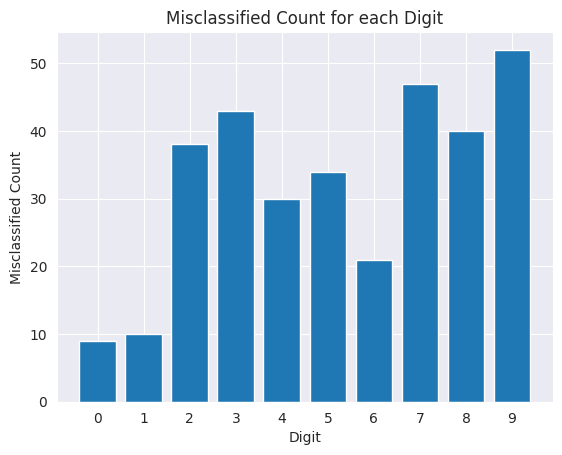

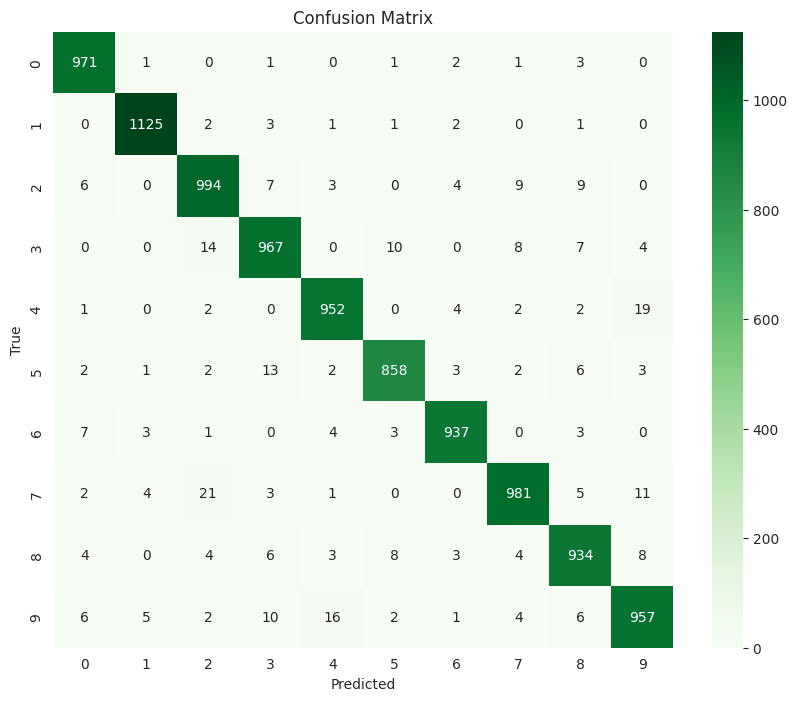

In [32]:
# on utilise les résultats de la prédictions pour les comparer aux résultats attendus pour chaque digit
misclassified_counts = np.zeros(10)

# on parcours les 9 digits
for digit in range(10):
  # un tableau avec tout les indices pour lesquels y_test[indice] == digit
  indices = np.where(loader.y_test == digit)[0]
  # à chaque fois que la prédiction est fausse on incrémente le misclassifies_count
  misclassified_count = np.sum(y_pred[indices] != loader.y_test[indices])
  misclassified_counts[digit] = misclassified_count


# affichage du tableau
digits = np.arange(10)
plt.bar(digits, misclassified_counts)
plt.xlabel('Digit')
plt.ylabel('Misclassified Count')
plt.title('Misclassified Count for each Digit')
plt.xticks(digits)
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
# matrice de confusion
cm = confusion_matrix(loader.y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d', xticklabels=digits, yticklabels=digits)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Partie supplémentaire : apprentissage non supervisé

In [33]:
# KMeans est un algo qui peut être entrainé sans lui préciser les réponses, donc non supervisé
from sklearn.cluster import KMeans

# Création de l'instance du modèle K-means
kmeans = KMeans(n_clusters=10, random_state=42)

# Ajustement du modèle aux données
kmeans.fit(loader.x_train_reshaped)

# Prédiction des clusters pour les données de test
y_pred = kmeans.predict(loader.x_test_reshaped)

# Évaluation des performances du modèle (si des étiquettes réelles sont disponibles)
accuracy = accuracy_score(loader.y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.1705


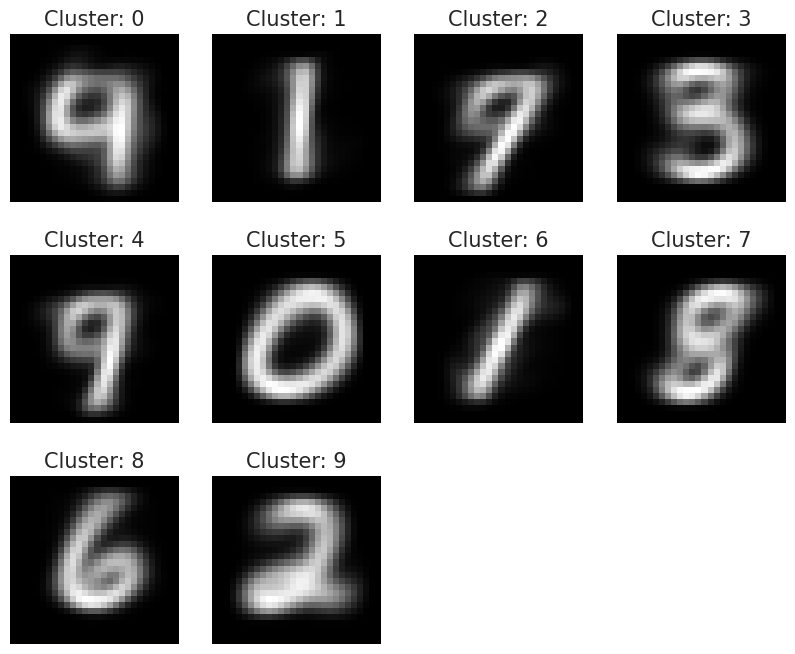

In [34]:
# affichage des centre de clusters
centroids = kmeans.cluster_centers_
# on reshape les images en tableau en 3 dimensions pour pouvoir les afficher
centroids = centroids.reshape(10, 28, 28)
plt.figure(figsize=(10, 11))
for i in range(10):
    plt.subplot(4, 4, i + 1)
    plt.title('Cluster: {}'.format(i), fontsize=15)
    plt.axis("off")
    plt.imshow(centroids[i], cmap='gray')
plt.show()

# apprentissage non supervisé - compte rendu
Très intéressant ! Les résultats ci-dessus sont les "centres de clusters" trouvé par le modèle KMeans.

Plus simplement, nous avons précisé au modèle à sa création qu'il devait diviser les données en 10 groupes - ou clusters.

au-dessus ce trouve les images correspondant au "centre de clusters", c'est à dire à l'élément qui, selon le modèle, est le plus représentatif de chaque cluster.

comme on peut le voir il n'as pas trouvé tout les clusters attendus mais à séparer les labels 1, 0 et 9 en plusieurs clusters.

Dans la mesure où l'on sait exactement qu'elles sont les réponses qu'on attends, l'apprentissage non supervisé n'est pas pertinent ici, mais le testé à été très intéressant.


# Partie supplémentaire 2 : exemple interactif

Dans cette partie on ouvre une fenêtre dans laquelle on peut déssiner un chiffre.

Après avoir correctement transformer l'image en un format compréhensible par le modèle, on fait faire une prédiction par le modèle.

Le résultat de la prédiction s'affiche en instantannée.

In [8]:
import tkinter as tk
from PIL import Image, ImageDraw

# Création de la fenêtre principale
window = tk.Tk()

# Création de la toile pour dessiner
canvas = tk.Canvas(window, width=280, height=280, bg='white')
canvas.pack()

# Création de l'image pour stocker le dessin
image = Image.new('L', (280, 280), 255)
draw = ImageDraw.Draw(image)

# Fonction pour effacer le dessin sur la toile et réinitialiser l'image
def clear_canvas():
    canvas.delete('all')
    global image, draw
    image = Image.new('L', (280, 280), 255)
    draw = ImageDraw.Draw(image)

# Bouton pour effacer le dessin
clear_button = tk.Button(window, text='Clear', command=clear_canvas)
clear_button.pack()


# Fonction appelée lors du dessin
def draw_on_canvas(event):
    x, y = event.x, event.y
    canvas.create_oval(x, y, x+10, y+10, fill='black')
    draw.rectangle([x, y, x+10, y+10], fill='black')

# Fonction appelée lors de la prédiction
def predict_digit():
    # Redimensionner l'image à la taille attendue par le modèle (28x28)
    resized_image = image.resize((28, 28))

    # Prétraitement de l'image pour l'adapter au modèle (conversion en tableau numpy, normalisation, etc.)
    preprocessed_image = preprocess_image(resized_image)

    # Effectuer la prédiction avec le modèle
    prediction = model.predict([preprocessed_image])

    # Afficher la prédiction
    prediction_label.config(text='Prediction: ' + str(prediction[0]))

# Fonction pour prétraiter l'image avant la prédiction
def preprocess_image(image):
    # Convertir l'image en niveaux de gris
    image = image.convert('L')

    # Convertir l'image en tableau numpy
    image_array = np.array(image)
    
    # on inverse le noir et le blanc, car le dessin s'affiche mieux sur fond blanc mais notre modèle est entrainé sur fond noir
    # en gros sur l'image 255 correspond à du vide alors que pour notre modèle 255 c'est une case dessinée par l'utilisateur
    final_array = 255 - image_array.flatten()
    return final_array

# Bouton pour effectuer la prédiction
predict_button = tk.Button(window, text='Predict', command=predict_digit)
predict_button.pack()

# Étiquette pour afficher la prédiction
prediction_label = tk.Label(window, text='Prediction: ')
prediction_label.pack()

# Capturer les événements de dessin sur la toile
canvas.bind('<B1-Motion>', draw_on_canvas)

# Lancer l'application
window.mainloop()